In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('train.csv')

#Drop de cosas que no necesitamos en dolar
dolar= pd.read_csv('Datos históricos USD_MXN.csv')
dolar.columns = ["fecha", "last", "opening", "max", "min", "std"]
dolar.drop(["std", "opening", "opening", "max", "min"], axis=1 ,inplace=True)

#Modificamos dolar para que se parezca al otro DF
dolar['date'] = pd.to_datetime(dolar['fecha'], format="%b %Y")
dolar.drop(["fecha"], axis=1, inplace=True)
dolar.columns= ['price', "date"]
dolar['price'] = dolar['price'].replace(',', '.', regex=True).astype(float)
dolar["year"] = dolar.date.dt.year
dolar['month'] = dolar.date.dt.month
dolar.drop(["date"], axis=1, inplace=True)

#Hacemos el merge, dejamos el precio dolar y el precio original
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].dt.year
df['month']= df['fecha'].dt.month
newDf= pd.merge(df, dolar, on=['year', 'month'], how='left')
newDf["dollar_price"] = newDf.apply(lambda row: row["precio"]/row["price"], axis=1)
df = newDf.filter(["id", "tipodepropiedad", "habitaciones",'garages', 'banos', 'ciudad',
                   'provincia','metroscubiertos', 'metrostotales', 'idzona', 'fecha',
                   'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
                   'centroscomercialescercanos', 'dollar_price','precio' ])

#Creamos la funcion
def asignarMetros(metroscubiertos, metrostotales):
    if (metroscubiertos != 0 and metrostotales == 0):
        return metroscubiertos
    else:
        return metrostotales
    
#Arreglando, no pueden haber propiedades con metros cubiertos pero sin metros totales
df['metrostotales'].fillna(0, inplace=True)
df['metrostotales'] = df.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)

###### FILTRO DE TERRENO #######
filtroTerreno = df["tipodepropiedad"].isin(["Huerta", "Nave industrial", "Terreno", "Terreno comercial",                                            "Bodega comercial", "Terreno industrial"])
dfTerreno = df[filtroTerreno]

####### FILTRO SI QUEREMOS CASAS Y COSAS COMO CASA #######
#Dropeo todos los terrenos que tienen habitaciones ya que si las tienen no serian terrenos.
dfTerreno = dfTerreno[dfTerreno["habitaciones"].isna()]

#Limpiando las propiedades tipo casa, no pueden no tener al menos una habitacion o baño y no pueden
#tener metros no cubiertos
filtro1 = df["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio",
                                        "Casa uso de suelo", "Rancho", "Quinta Vacacional"])
dfCasas = df[filtro1]
dfCasas = dfCasas[np.isfinite(dfCasas['habitaciones'])]
dfCasas = dfCasas[np.isfinite(dfCasas['banos'])]
dfCasas = dfCasas[np.isfinite(dfCasas['metroscubiertos'])]
dfCasas.garages.fillna(0, inplace=True)

df = pd.merge(dfCasas, dfTerreno, on=['id', 'tipodepropiedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos'
                                      ,'ciudad','provincia','metrostotales','idzona','fecha', 'gimnasio','usosmultiples',
                                       'piscina','escuelascercanas','centroscomercialescercanos', 'dollar_price','precio'], how='outer')


#### DE ACA EN ADELANTE, USAR DF #####

In [2]:
df2 = df
df2['fecha_month'] = df2['fecha'].dt.month
df2['fecha_year'] = df2['fecha'].dt.year
for_heatmap_mexican = df2.pivot_table(index='fecha_year', columns='fecha_month', values='dollar_price', aggfunc='mean')
for_heatmap_dollar = df2.pivot_table(index='fecha_year', columns='fecha_month', values='precio', aggfunc='mean')


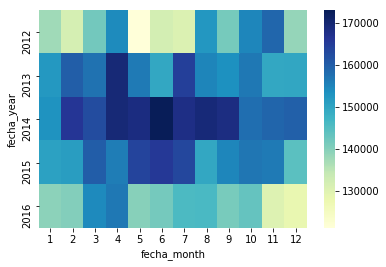

In [3]:
g = sns.heatmap(for_heatmap_mexican,  cmap="YlGnBu")

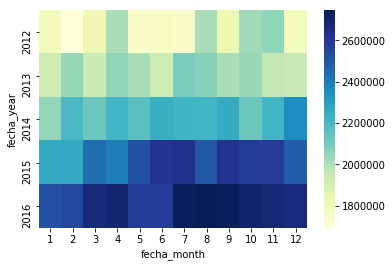

In [4]:
h = sns.heatmap(for_heatmap_dollar, cmap="YlGnBu")